# What should we plot?

* Results for individual $\varepsilon$ for some protection scheme

In [2]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from online_cp import PluginMartingale
from online_cp import ConformalNearestNeighboursClassifier
rnd_gen = np.random.default_rng(2024)

plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats

# Set the desired output format
set_matplotlib_formats('svg')

from tol_colors import tol_cmap, tol_cset
cmap = tol_cset('bright')

import pandas as pd

In [3]:
dataset = 'usps'
df_p_values = pd.read_csv(f'../data/data_protected_conformal_classification/p_values_{dataset}.csv')
if dataset == 'usps':
    df_p_values['label'] = df_p_values['label'].astype(int)

In [4]:
label_space = df_p_values.columns[:-1]
res = np.zeros(shape=(df_p_values.shape[0], 6))
prediction_sets = {}
protected_prediction_sets = {}

cp = ConformalNearestNeighboursClassifier(k=1, label_space=df_p_values.columns[:-1]) # Just a dummy to collect the protected results
protected_cp = ConformalNearestNeighboursClassifier(k=1, label_space=df_p_values.columns[:-1]) # Just a dummy to collect the protected results

min_sample_size = 100
mixing_exponent = 1
window_size = 'adaptive'
martingale = PluginMartingale(warnings=False, window_size=window_size, min_sample_size=min_sample_size, mixing_exponent=mixing_exponent)
calibration_martingale = PluginMartingale(warnings=False, min_sample_size=min_sample_size, mixing_exponent=mixing_exponent)

epsilon = 0.1

for i, row in tqdm(df_p_values.iterrows(), total=df_p_values.shape[0]):
    p_values = row.to_dict()
    if dataset == 'usps' or dataset == 'satlog':
        lab = str(int(p_values.pop('label')))
    else:
        lab = str(p_values.pop('label'))
    Gamma = cp._compute_Gamma(p_values=p_values, epsilon=epsilon)

    # Apply protection
    protected_p_values = {}
    for label, p in p_values.items():
        protected_p_values[label] = martingale.B_n(p)

    protected_Gamma = protected_cp._compute_Gamma(p_values=protected_p_values, epsilon=epsilon)

    # Check error
    cp.err(Gamma, lab)
    protected_cp.err(protected_Gamma, lab)

    # Update martingale
    martingale.update_martingale_value(p_values[lab])
    calibration_martingale.update_martingale_value(protected_p_values[lab])

    # Prefferred efficiency criteria

    # Observed excess
    cp.oe(Gamma, lab)
    protected_cp.oe(protected_Gamma, lab)

    # Observed fuzziness
    cp.of(p_values, lab)
    protected_cp.of(protected_p_values, lab)

    res[i, 0] = cp.OE
    res[i, 1] = cp.OF
    res[i, 2] = cp.Err
    prediction_sets[i] = Gamma
    res[i, 3] = protected_cp.OE
    res[i, 4] = protected_cp.OF
    res[i, 5] = protected_cp.Err
    protected_prediction_sets[i] = protected_Gamma

  0%|          | 0/9298 [00:00<?, ?it/s]

# Basic plot

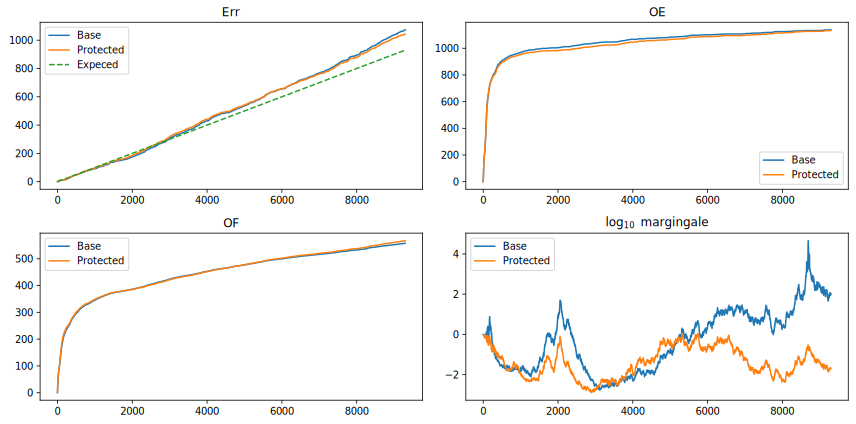

In [5]:
change_point = 4898

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 6))

ax[0, 0].plot(res[:, 2], label='Base')
ax[0, 0].plot(res[:, 5], label='Protected')
if dataset == 'wine_change_point':
    ax[1, 0].axvline(change_point, label='Change point', linestyle='--', color='red')
# ax[1, 0].plot(rnd_gen.binomial(n=1, p=0.1, size=Y.shape[0]).cumsum(), linestyle='--', label='Cumulative Bernoulli')
ax[0, 0].plot(list(epsilon*i for i in range(df_p_values.shape[0])), linestyle='--', label='Expeced')
ax[0, 0].set_title('Err')
ax[0, 0].legend()

ax[0, 1].plot(res[:, 0], label='Base')
ax[0, 1].plot(res[:, 3], label='Protected')
if dataset == 'wine_change_point':
    ax[0, 1].axvline(change_point, label='Change point', linestyle='--', color='red')
ax[0, 1].set_title('OE')
ax[0, 1].legend()

ax[1, 0].plot(res[:, 1], label='Base')
ax[1, 0].plot(res[:, 4], label='Protected')
if dataset == 'wine_change_point':
    ax[0, 1].axvline(change_point, label='Change point', linestyle='--', color='red')
ax[1, 0].set_title('OF')
ax[1, 0].legend()


ax[1, 1].plot(martingale.log10_martingale_values, label='Base')
ax[1, 1].plot(calibration_martingale.log10_martingale_values, label='Protected')
if dataset == 'wine_change_point':
    ax[1, 1].axvline(change_point, label='Change point', linestyle='--', color='red')
ax[1, 1].set_title(r'$\log_{10}$' + ' margingale')
ax[1, 1].legend()

fig.tight_layout()

# fig.savefig(f'../data/data_protected_conformal_classification/plots/{dataset}_epsilon_{epsilon}.pdf')

In [6]:
cp.Err/df_p_values.shape[0], protected_cp.Err/df_p_values.shape[0]

(0.11540116154011615, 0.11228221122822113)

In [7]:
protected_cp.OE - cp.OE

-5

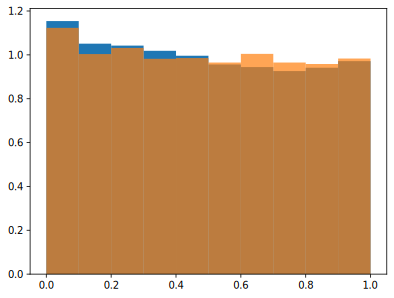

In [8]:
M = 100000
plt.hist(martingale.p_values[-M:], density=True)
plt.hist(calibration_martingale.p_values[-M:], density=True, alpha=0.7)
xrange = np.linspace(0, 1, endpoint=True, num=1000)
# plt.plot(xrange, martingale.b_n(xrange))
# plt.plot(xrange, calibration_martingale.b_n(xrange))
# plt.tight_layout()
# plt.savefig('wine_original_order_hist.pdf')

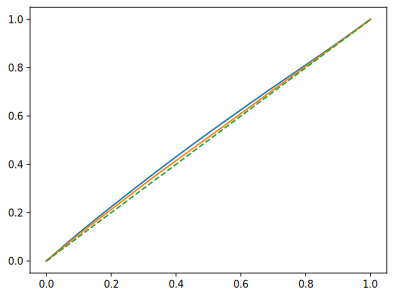

In [9]:
plt.plot(
    xrange,
    martingale.B_n(xrange)
)
plt.plot(
    xrange,
    calibration_martingale.B_n(xrange)
)
plt.plot(
    xrange,
    xrange,
    linestyle='--'
)

# All significance levels

In [10]:
label_space = df_p_values.columns[:-1]

min_sample_size = 1000
mixing_exponent = 1

Epsilon = np.linspace(0.001, 1, 1000, endpoint=False)

var_res = np.zeros(shape=(Epsilon.shape[0], 6))

# martingale = PluginMartingale(warnings=False, min_sample_size=min_sample_size, mixing_exponent=mixing_exponent)
martingale = PluginMartingale(warnings=False, window_size=window_size, min_sample_size=min_sample_size, mixing_exponent=mixing_exponent)
calibration_martingale = PluginMartingale(warnings=False, min_sample_size=min_sample_size, mixing_exponent=mixing_exponent)

P_values = []
P_values_protected = []
Y = np.zeros(df_p_values.shape[0])

for i, row in tqdm(df_p_values.iterrows(), total=df_p_values.shape[0], desc='Protecting p-values'):
    p_values = row.to_dict()
    if dataset == 'usps' or dataset == 'satlog':
        lab = str(int(p_values.pop('label')))
    else:
        lab = str(p_values.pop('label'))
    P_values.append(p_values)

    Y[i] = lab

    # Apply protection
    protected_p_values = {}
    for label, p in p_values.items():
        protected_p_values[label] = martingale.B_n(p)
    P_values_protected.append(protected_p_values)

    martingale.update_martingale_value(p_values[lab])
    calibration_martingale.update_martingale_value(protected_p_values[lab])

for j, epsilon in tqdm(enumerate(Epsilon), total=Epsilon.shape[0], desc='Making predictions'):

    cp = ConformalNearestNeighboursClassifier(k=1, label_space=df_p_values.columns[:-1]) # Just a dummy to collect the results
    protected_cp = ConformalNearestNeighboursClassifier(k=1, label_space=df_p_values.columns[:-1]) # Just a dummy to collect the protected results

    for p_values, protected_p_values, lab in zip(P_values, P_values_protected, Y):
        if dataset == 'usps' or dataset == 'satlog':
            lab = str(int(lab))
        else:
            lab = str(lab)
        Gamma = cp._compute_Gamma(p_values=p_values, epsilon=epsilon)

        # Apply protection
        protected_Gamma = protected_cp._compute_Gamma(p_values=protected_p_values, epsilon=epsilon)

        # Check error
        cp.err(Gamma, lab)
        protected_cp.err(protected_Gamma, lab)

        # Prefferred efficiency criteria

        # Observed excess
        cp.oe(Gamma, lab)
        protected_cp.oe(protected_Gamma, lab)

        # Observed fuzziness
        cp.of(p_values, lab)
        protected_cp.of(protected_p_values, lab)

    var_res[j, 0] = cp.Err
    var_res[j, 1] = cp.OE
    var_res[j, 2] = cp.OF

    var_res[j, 3] = protected_cp.Err
    var_res[j, 4] = protected_cp.OE
    var_res[j, 5] = protected_cp.OF

Protecting p-values:   0%|          | 0/9298 [00:00<?, ?it/s]

Making predictions:   0%|          | 0/1000 [00:00<?, ?it/s]

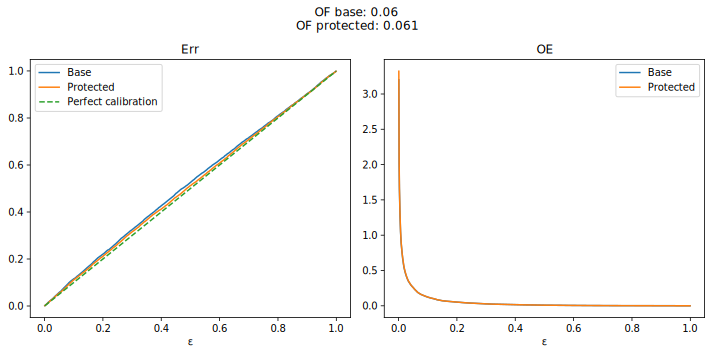

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs[0].plot(Epsilon, var_res[:,0]/df_p_values.shape[0], label='Base')
axs[0].plot(Epsilon, var_res[:,3]/df_p_values.shape[0], label='Protected')
axs[0].plot(Epsilon, Epsilon, linestyle='--', label='Perfect calibration')
axs[0].set_title('Err')
axs[0].set_xlabel(r'$\varepsilon$')

# xrange = np.linspace(0, 1, num=1000)
# axs[0].plot(
#     xrange,
#     martingale.B_n(xrange),
#     label=r'$B_n$'
# )
# axs[0].plot(
#     xrange,
#     calibration_martingale.B_n(xrange),
#     label=r'$B_n$ cal'
# )
axs[0].legend()

axs[1].plot(Epsilon, var_res[:,1]/df_p_values.shape[0], label='Base')
axs[1].plot(Epsilon, var_res[:,4]/df_p_values.shape[0], label='Protected')
axs[1].set_title('OE')
axs[1].set_xlabel(r'$\varepsilon$')
axs[1].legend()

# axs[2].plot(martingale.log10_martingale_values, label='Base')
# axs[2].plot(calibration_martingale.log10_martingale_values, label='Protected')
# axs[2].set_title(r'$\log_{10}$ martingale')
# axs[2].legend()

fig.suptitle(f'OF base: {var_res[:,2].mean()/df_p_values.shape[0]:.2}\nOF protected: {var_res[:,5].mean()/df_p_values.shape[0]:.2}')

fig.tight_layout()

# fig.savefig(f'../data/data_protected_conformal_classification/plots/{dataset}_all_epsilon.pdf')